<a href="https://colab.research.google.com/github/String-ru/AIFFEL_quest_cr/blob/main/Exploration/Quest01/250408_flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers 이미지 분류기 프로젝트 C1-2

- **런타임**: GPU(T3) 사용

In [16]:
# GPU 할당 확인
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print("GPU:", device_name)

GPU: /device:GPU:0


### 1. 데이터 로드 및 분할
- `tf_flowers` 데이터셋: 5개 Class(데이지, 민들레, 장미, 해바라기, 튤립)
- train/validation/test 비율: 80% / 10% / 10%

In [17]:
import tensorflow_datasets as tfds

# 데이터 다운로드
(raw_train, raw_val, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,  # (image, label) 튜플 반환
)
class_names = metadata.features['label'].names
print("Classes:", class_names)

Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


### 2. 데이터 전처링
- **리사이즈**: VGG16 입력 크기 (224,224)
- **정규화**: [0,255] → [0,1]
- **데이터 증강**: (train에만) 회전, 플립 등

In [18]:
BATCH_SIZE = 32
IMG_SIZE = 224

def format_image(image, label):
    """이미지를 리사이즈하고 [0,1] 범위로 정규화합니다."""
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

def augment(image, label):
    """데이터 증강: 랜덤 회전, 플립"""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

# 파이프라인 구성
train_batches = (
    raw_train
    .map(format_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
validation_batches = (
    raw_val
    .map(format_image)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
test_batches = (
    raw_test
    .map(format_image)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

### 3. 모델 구성
- **모델 선정**: VGG16
- **전이 학습**: imagenet 가중치 사용, 상위 레이어 동결(freeze) → feature extractor로 활용
- **하이퍼파라미터**:
  - optimizer: Adam
  - learning rate: 1e-4 (초기 실험 후 결정)
  - dropout rate: 0.5 (과적합 방지)

In [19]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# 베이스 모델 불러오기 (동결)
base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                   include_top=False,
                   weights='imagenet')
base_model.trainable = False

# 분류기 헤드 추가
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),  # 배치 정규화
    layers.Dropout(0.5),           # 드롭아웃
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,781 (80.64 MB)

 Trainable params: 6,424,581 (24.51 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

### 4. 모델 학습
- **Epoch**: 15
- **Batch size**: 32
- **Optimizer**: Adam(learning_rate=1e-4)
- **Loss**: SparseCategoricalCrossentropy
- **Metrics**: accuracy

In [20]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_batches,
    epochs=15,
    validation_data=validation_batches
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 407ms/step - accuracy: 0.5785 - loss: 1.3660 - val_accuracy: 0.6076 - val_loss: 1.0375
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 186ms/step - accuracy: 0.7794 - loss: 0.6278 - val_accuracy: 0.7575 - val_loss: 0.6085
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - accuracy: 0.8470 - loss: 0.4291 - val_accuracy: 0.8038 - val_loss: 0.5325
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.8974 - loss: 0.3057 - val_accuracy: 0.8229 - val_loss: 0.4961
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 190ms/step - accuracy: 0.9093 - loss: 0.2561 - val_accuracy: 0.8093 - val_loss: 0.5856
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - accuracy: 0.9295 - loss: 0.2160 - val_accuracy: 0.7902 - val_loss: 0.6022
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.9441 - loss: 0.1795 - val_accuracy: 0.8202 - val_loss: 0.5806
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.9501 - loss: 0.1577 - val_accu

### 5. 성능 평가 및 시각화

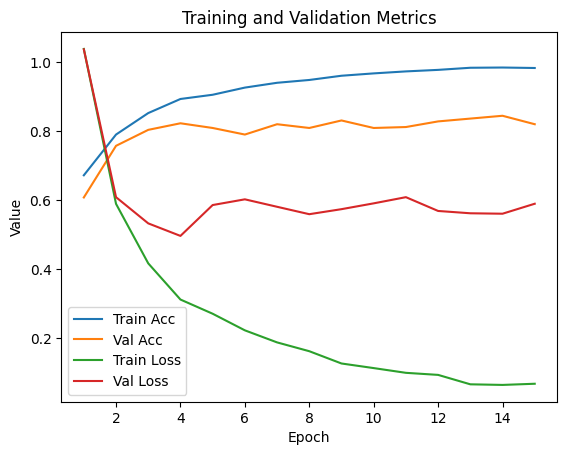

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.8323 - loss: 0.4947
Test Accuracy: 0.8638


In [21]:
import matplotlib.pyplot as plt

# 학습 곡선 그리기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Metrics')
plt.show()

# 테스트 평가
test_loss, test_acc = model.evaluate(test_batches)
print(f"Test Accuracy: {test_acc:.4f}")

# 6. 모델 활용
## 7가지 외부image 적용 결과

#올바르게 예측한 경우 6개

Saving mindulle.png to mindulle (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


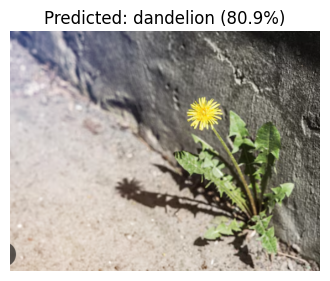

=== 클래스별 예측 확률 ===
dandelion :  80.9%
daisy     :   7.6%
tulips    :   2.9%
sunflowers:   4.9%
roses     :   3.6%


In [23]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 업로드
uploaded = files.upload()

for fn in uploaded.keys():
    # 1) 이미지 로드 및 전처리
    img = Image.open(fn).convert('RGB')
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    x = np.array(img_resized) / 255.0
    x = np.expand_dims(x, axis=0)  # 배치 차원 추가

    # 2) 예측
    preds = model.predict(x)[0]  # (1,5) -> (5,)
    top_idx = np.argmax(preds)
    pred_class = class_names[top_idx]
    pred_prob = preds[top_idx]

    # 3) 원본 이미지 표시
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({pred_prob*100:.1f}%)")
    plt.show()

    # 4) 클래스별 확률 출력
    print("=== 클래스별 예측 확률 ===")
    for cls, prob in zip(class_names, preds):
        print(f"{cls:10s}: {prob*100:5.1f}%")

Saving daisy.png to daisy.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


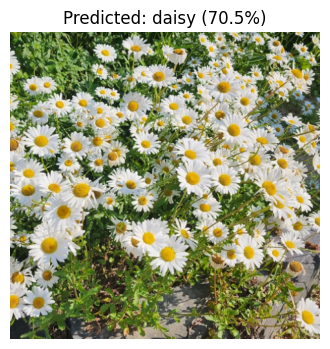

=== 클래스별 예측 확률 ===
dandelion :   0.6%
daisy     :  70.5%
tulips    :   0.2%
sunflowers:  27.4%
roses     :   1.3%


In [24]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 업로드
uploaded = files.upload()

for fn in uploaded.keys():
    # 1) 이미지 로드 및 전처리
    img = Image.open(fn).convert('RGB')
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    x = np.array(img_resized) / 255.0
    x = np.expand_dims(x, axis=0)  # 배치 차원 추가

    # 2) 예측
    preds = model.predict(x)[0]  # (1,5) -> (5,)
    top_idx = np.argmax(preds)
    pred_class = class_names[top_idx]
    pred_prob = preds[top_idx]

    # 3) 원본 이미지 표시
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({pred_prob*100:.1f}%)")
    plt.show()

    # 4) 클래스별 확률 출력
    print("=== 클래스별 예측 확률 ===")
    for cls, prob in zip(class_names, preds):
        print(f"{cls:10s}: {prob*100:5.1f}%")

Saving english_daisy.png to english_daisy.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


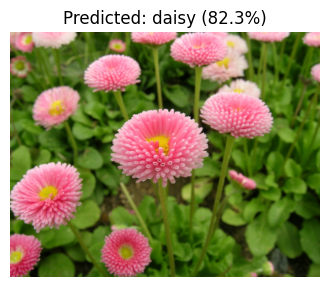

=== 클래스별 예측 확률 ===
dandelion :  17.3%
daisy     :  82.3%
tulips    :   0.0%
sunflowers:   0.0%
roses     :   0.3%


In [25]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 업로드
uploaded = files.upload()

for fn in uploaded.keys():
    # 1) 이미지 로드 및 전처리
    img = Image.open(fn).convert('RGB')
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    x = np.array(img_resized) / 255.0
    x = np.expand_dims(x, axis=0)  # 배치 차원 추가

    # 2) 예측
    preds = model.predict(x)[0]  # (1,5) -> (5,)
    top_idx = np.argmax(preds)
    pred_class = class_names[top_idx]
    pred_prob = preds[top_idx]

    # 3) 원본 이미지 표시
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({pred_prob*100:.1f}%)")
    plt.show()

    # 4) 클래스별 확률 출력
    print("=== 클래스별 예측 확률 ===")
    for cls, prob in zip(class_names, preds):
        print(f"{cls:10s}: {prob*100:5.1f}%")

Saving rose_yellow.png to rose_yellow.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


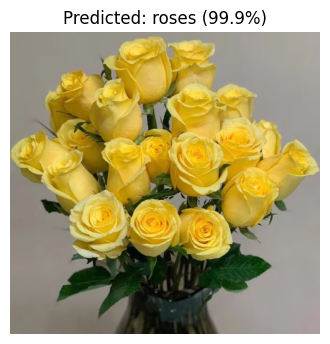

=== 클래스별 예측 확률 ===
dandelion :   0.0%
daisy     :   0.0%
tulips    :   0.1%
sunflowers:   0.0%
roses     :  99.9%


In [26]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 업로드
uploaded = files.upload()

for fn in uploaded.keys():
    # 1) 이미지 로드 및 전처리
    img = Image.open(fn).convert('RGB')
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    x = np.array(img_resized) / 255.0
    x = np.expand_dims(x, axis=0)  # 배치 차원 추가

    # 2) 예측
    preds = model.predict(x)[0]  # (1,5) -> (5,)
    top_idx = np.argmax(preds)
    pred_class = class_names[top_idx]
    pred_prob = preds[top_idx]

    # 3) 원본 이미지 표시
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({pred_prob*100:.1f}%)")
    plt.show()

    # 4) 클래스별 확률 출력
    print("=== 클래스별 예측 확률 ===")
    for cls, prob in zip(class_names, preds):
        print(f"{cls:10s}: {prob*100:5.1f}%")

Saving tulip.png to tulip.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


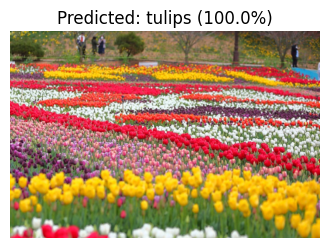

=== 클래스별 예측 확률 ===
dandelion :   0.0%
daisy     :   0.0%
tulips    : 100.0%
sunflowers:   0.0%
roses     :   0.0%


In [27]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 업로드
uploaded = files.upload()

for fn in uploaded.keys():
    # 1) 이미지 로드 및 전처리
    img = Image.open(fn).convert('RGB')
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    x = np.array(img_resized) / 255.0
    x = np.expand_dims(x, axis=0)  # 배치 차원 추가

    # 2) 예측
    preds = model.predict(x)[0]  # (1,5) -> (5,)
    top_idx = np.argmax(preds)
    pred_class = class_names[top_idx]
    pred_prob = preds[top_idx]

    # 3) 원본 이미지 표시
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({pred_prob*100:.1f}%)")
    plt.show()

    # 4) 클래스별 확률 출력
    print("=== 클래스별 예측 확률 ===")
    for cls, prob in zip(class_names, preds):
        print(f"{cls:10s}: {prob*100:5.1f}%")

Saving sunflower2_VanGogh.png to sunflower2_VanGogh.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


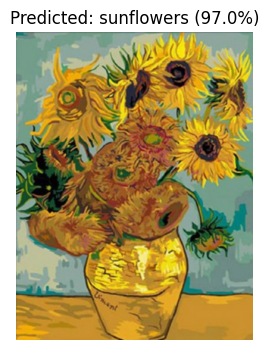

=== 클래스별 예측 확률 ===
dandelion :   0.0%
daisy     :   0.4%
tulips    :   0.0%
sunflowers:  97.0%
roses     :   2.6%


In [29]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 업로드
uploaded = files.upload()

for fn in uploaded.keys():
    # 1) 이미지 로드 및 전처리
    img = Image.open(fn).convert('RGB')
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    x = np.array(img_resized) / 255.0
    x = np.expand_dims(x, axis=0)  # 배치 차원 추가

    # 2) 예측
    preds = model.predict(x)[0]  # (1,5) -> (5,)
    top_idx = np.argmax(preds)
    pred_class = class_names[top_idx]
    pred_prob = preds[top_idx]

    # 3) 원본 이미지 표시
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({pred_prob*100:.1f}%)")
    plt.show()

    # 4) 클래스별 확률 출력
    print("=== 클래스별 예측 확률 ===")
    for cls, prob in zip(class_names, preds):
        print(f"{cls:10s}: {prob*100:5.1f}%")

#해바라기를 장미라고 잘못 예측한 예시 1개

Saving sunflower_VanGogh.png to sunflower_VanGogh.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


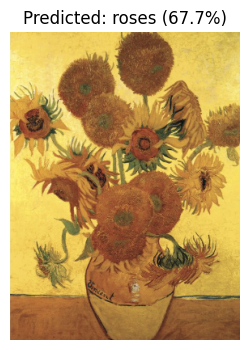

=== 클래스별 예측 확률 ===
dandelion :   0.5%
daisy     :   0.1%
tulips    :   1.1%
sunflowers:  30.6%
roses     :  67.7%


In [28]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 업로드
uploaded = files.upload()

for fn in uploaded.keys():
    # 1) 이미지 로드 및 전처리
    img = Image.open(fn).convert('RGB')
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    x = np.array(img_resized) / 255.0
    x = np.expand_dims(x, axis=0)  # 배치 차원 추가

    # 2) 예측
    preds = model.predict(x)[0]  # (1,5) -> (5,)
    top_idx = np.argmax(preds)
    pred_class = class_names[top_idx]
    pred_prob = preds[top_idx]

    # 3) 원본 이미지 표시
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class} ({pred_prob*100:.1f}%)")
    plt.show()

    # 4) 클래스별 확률 출력
    print("=== 클래스별 예측 확률 ===")
    for cls, prob in zip(class_names, preds):
        print(f"{cls:10s}: {prob*100:5.1f}%")